# **Configurazioni**

In [1]:
!pip install pykan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 kB 2.3 MB/s eta 0:00:00


In [23]:
import sys
import time
sys.path.append('/content/pykan/kan')
sys.path.append('/content/pykan/kan/KAN.py')
from kan import *
import torch
import numpy as np
import sympy as sp
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# **Dataset**

In [44]:
#Lettura del dataset
file_path = 'https://raw.githubusercontent.com/LucaA0111/Reti-Kolmogorov-Arnold-e-Multilayer-Perceptron-Un-Confronto-Sperimentale/refs/heads/main/Train%20Delay/railway.csv'

df = pd.read_csv(file_path, sep=";")

df

,Distance Between Stations,Weather Conditions,Day of the Week,Time of Day,Train Type,Delay,Route Congestion
0,100,Clear,Monday,Morning,Express,5,Low
1,150,Rainy,Tuesday,Afternoon,Superfast,10,Medium
2,200,Foggy,Wednesday,Evening,Local,15,High
3,50,Clear,Thursday,Night,Express,2,Low
4,75,Rainy,Friday,Morning,Superfast,8,Medium
...,...,...,...,...,...,...,...
2873,945,Clear,Tuesday,Night,Local,1210,Medium
2874,925,Rainy,Wednesday,Morning,Express,1215,High
2875,950,Foggy,Thursday,Afternoon,Superfast,1220,Low
2876,930,Clear,Friday,Evening,Local,1225,Medium


In [5]:
#Individuo colonne con eventuali valori nulli
nulls = df.isnull().sum().sort_values(ascending=False)
nulls = nulls[nulls > 0]
nulls_percentage = nulls / len(df) * 100
nulls_percentage

,0


In [6]:
#Sostituzione di stringhe con interi

#Weather Conditions
df['Weather Conditions'] = df['Weather Conditions'].replace({'Clear': 0, 'Rainy': 1,'Foggy': 2})

#Day of the Week
df['Day of the Week'] = df['Day of the Week'].replace({'Monday': 0, 'Tuesday': 1,'Wednesday': 2,'Thursday': 3,'Friday': 4, "Saturday": 5,'Sunday': 6})

#Time of Day
df['Time of Day'] = df['Time of Day'].replace({'Morning': 0, 'Afternoon': 1,'Evening': 2,'Night': 3})

#Train Type
df['Train Type'] = df['Train Type'].replace({'Local': 0, 'Express': 1,'Superfast': 2})

#Route Congestion
df['Route Congestion'] = df['Route Congestion'].replace({'Low': 0, 'Medium': 1,'High': 2})

df.head()

,Distance Between Stations,Weather Conditions,Day of the Week,Time of Day,Train Type,Delay,Route Congestion
0,100,0,0,0,1,5,0
1,150,1,1,1,2,10,1
2,200,2,2,2,0,15,2
3,50,0,3,3,1,2,0
4,75,1,4,0,2,8,1


In [7]:
#Rimozione outilers

# Calcolo dei quartili e dell'IQR
Q1 = df['Delay'].quantile(0.25)
Q3 = df['Delay'].quantile(0.75)
IQR = Q3 - Q1

# Definizione dei limiti
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Rimozione degli outlier
df = df[(df['Delay'] >= lower_bound) & (df['Delay'] <= upper_bound)]

df

,Distance Between Stations,Weather Conditions,Day of the Week,Time of Day,Train Type,Delay,Route Congestion
0,100,0,0,0,1,5,0
1,150,1,1,1,2,10,1
2,200,2,2,2,0,15,2
3,50,0,3,3,1,2,0
4,75,1,4,0,2,8,1
...,...,...,...,...,...,...,...
2660,390,0,5,2,0,145,1
2661,415,1,6,3,1,150,2
2662,395,2,0,0,2,155,0
2663,420,0,1,1,0,160,1


In [8]:
#Divido il datatset
X = df.drop(columns=['Delay'], axis = 1)  # Rimuovi la colonna delle etichette
y = df['Delay']  # Seleziona solo la colonna delle etichette

# 20% del datatset riservato per i test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
#Standardizzazione dei dati
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **Rete KAN**

In [10]:
#Conversione in tensori Pytorch per poterli utilizzare nella rete
dataset = {}

dataset['train_input'] = torch.from_numpy(X_train.astype(np.float32))
dataset['train_label'] = torch.from_numpy(y_train.values)
dataset['test_input'] = torch.from_numpy(X_test.astype(np.float32))
dataset['test_label'] = torch.from_numpy(y_test.values)

In [11]:
#Inizializzazione del modello

KAN_model = KAN(width=[X.shape[1],3,1], grid=4, k=3, seed = 0)

checkpoint directory created: ./model
saving model version 0.0


In [12]:
def train_acc():
    return torch.mean((torch.argmax(KAN_model(dataset['train_input']), dim=1) == dataset['train_label']).type(dtype=torch.float32))

def test_acc():
    return torch.mean((torch.argmax(KAN_model(dataset['test_input']), dim=1) == dataset['test_label']).type(dtype=torch.float32))

#Allenamento della rete
KAN_start_time1 = time.time()

KAN_results = KAN_model.fit(dataset, opt="Adam", steps=20, metrics=(train_acc, test_acc))

KAN_end_time1 = time.time()
KAN_training1_time = KAN_end_time1 - KAN_start_time1

| train_loss: 3.65e+01 | test_loss: 3.61e+01 | reg: 5.17e+01 | : 100%|█| 20/20 [00:04<00:00,  4.49it

saving model version 0.1


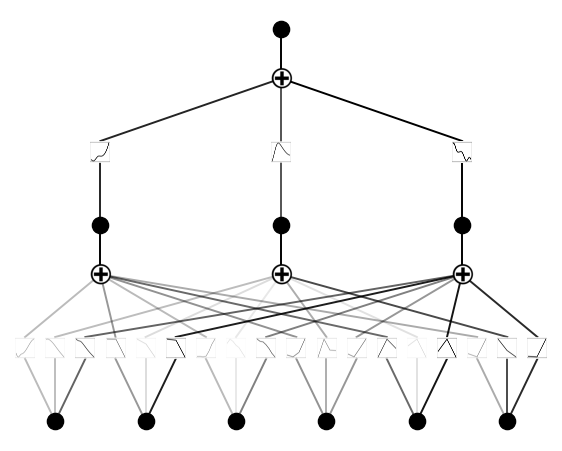

In [13]:
#Visualizzare lo stato inziale della rete KAN
KAN_model(dataset['train_input'])
KAN_model.plot(scale = 0.7)

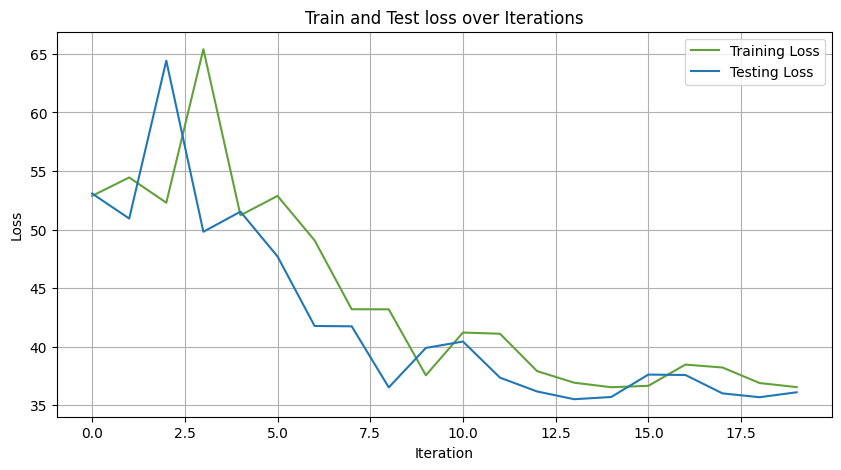

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(KAN_results["train_loss"], label='Training Loss', color='#61a13a')
plt.plot(KAN_results["test_loss"], label='Testing Loss')
plt.title('Train and Test loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

saving model version 0.2


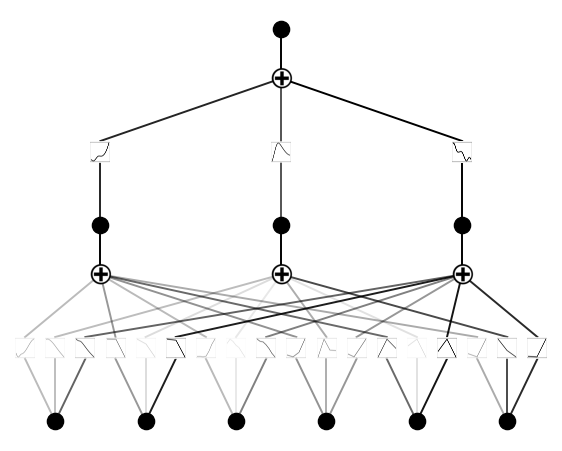

In [15]:
KAN_model = KAN_model.prune_node()
KAN_model.plot(scale = 0.7)

In [16]:
KAN_start_time2 = time.time()

KAN_new_results = KAN_model.fit(dataset, opt="Adam", steps=20, metrics=(train_acc, test_acc));

KAN_end_time2 = time.time()
KAN_training2_time = KAN_end_time2 - KAN_start_time2

| train_loss: 3.64e+01 | test_loss: 3.55e+01 | reg: 1.19e+02 | : 100%|█| 20/20 [00:02<00:00,  7.24it

saving model version 0.3


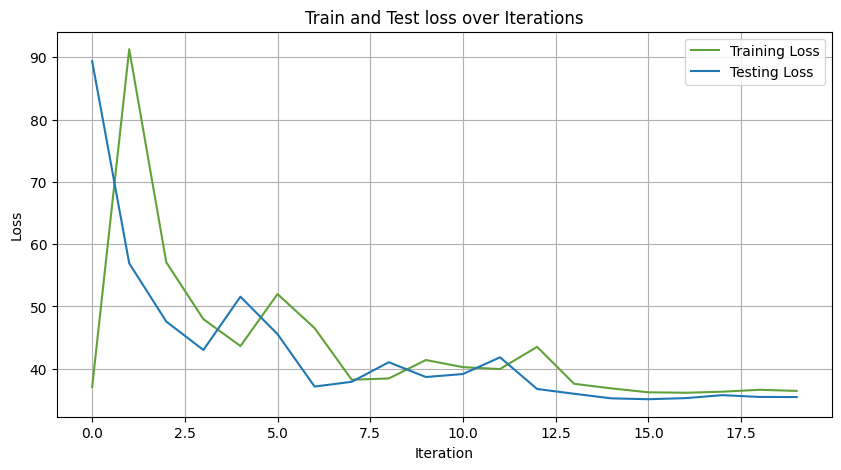

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(KAN_new_results["train_loss"], label='Training Loss', color='#61a13a')
plt.plot(KAN_new_results["test_loss"], label='Testing Loss')
plt.title('Train and Test loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
KAN_predictions = KAN_model.forward(dataset['test_input']).detach()

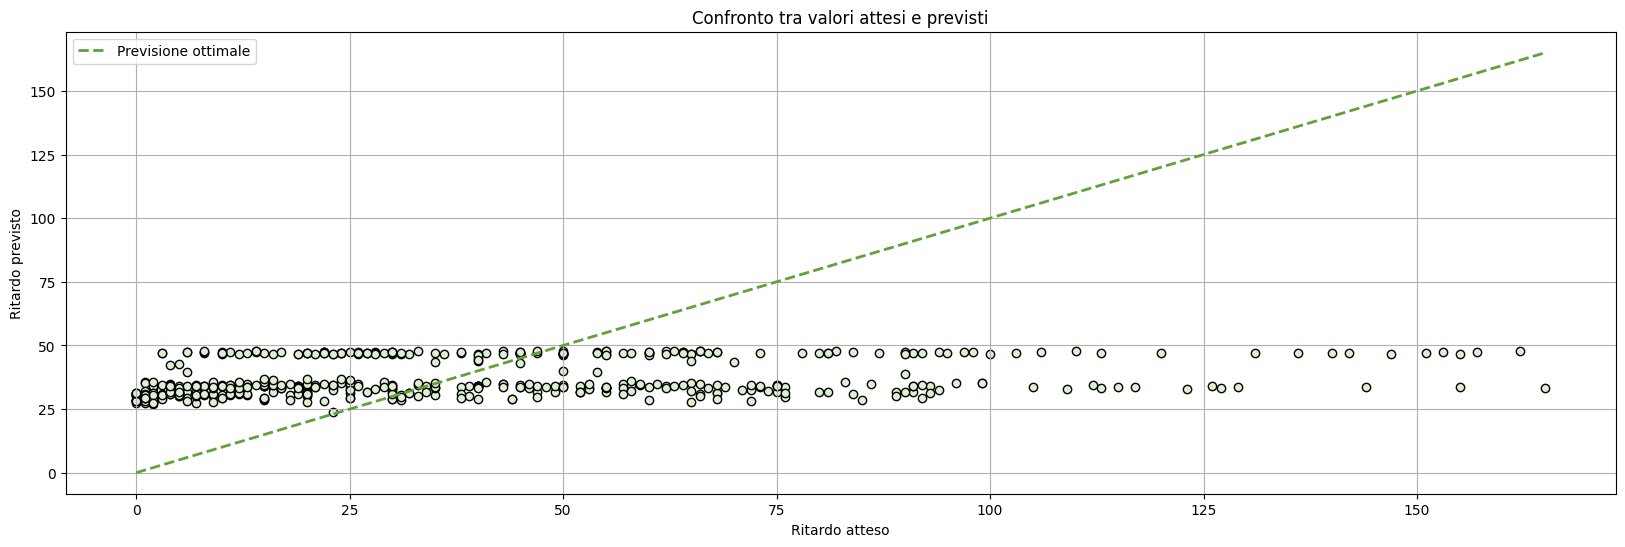

In [19]:
# Grafico Valori attesi vs valori previsti
plt.figure(figsize=(20, 6))
plt.scatter(dataset['test_label'], KAN_predictions, color="#ddf0d2",edgecolors='black', alpha = 1)
plt.plot([dataset['test_label'].min(), dataset['test_label'].max()], [dataset['test_label'].min(), dataset['test_label'].max()], color='#61a13a', linestyle='--', label='Previsione ottimale',  linewidth=2)
plt.xlabel('Ritardo atteso')
plt.ylabel('Ritardo previsto')
plt.legend()
plt.title('Confronto tra valori attesi e previsti')
plt.grid()
plt.show()

In [21]:
#Valuto il modello
KAN_r2 = r2_score(y_test, KAN_predictions.numpy())
KAN_mae = mean_absolute_error(y_test, KAN_predictions.numpy())
KAN_mse = mean_squared_error(y_test, KAN_predictions.numpy())
KAN_time = KAN_training1_time + KAN_training2_time

print("R²: ", KAN_r2)

print("Errore assoluto medio: ",KAN_mae )

print("Errore quadratico medio: ",KAN_mse )

print("Tempo di addestramento (s): ",KAN_time )

R²:  0.08720755577087402
Errore assoluto medio:  25.976241677999496
Errore quadratico medio:  1101.3828900880087
Tempo di addestramento (s):  7.2680439949035645


## Formula simbolica

In [42]:
#Imposto le funzioni di attivazione simboliche
lib = ['x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
KAN_model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.9801223874092102, c=2
fixing (0,0,1) with sin, r2=0.8578067421913147, c=2
fixing (0,0,2) with sqrt, r2=0.9617827534675598, c=2
fixing (0,1,0) with x^2, r2=1.0000005960464478, c=2
fixing (0,1,1) with x^2, r2=1.0000005960464478, c=2
fixing (0,1,2) with exp, r2=1.0000007152557373, c=2
fixing (0,2,0) with x^2, r2=0.9790277481079102, c=2
fixing (0,2,1) with sqrt, r2=0.9659068584442139, c=2
fixing (0,2,2) with sin, r2=0.9651318788528442, c=2
fixing (0,3,0) with log, r2=0.9419922828674316, c=2
fixing (0,3,1) with sin, r2=0.9999235272407532, c=2
fixing (0,3,2) with sin, r2=1.0000004768371582, c=2
fixing (0,4,0) with x^2, r2=1.0000005960464478, c=2
fixing (0,4,1) with x^2, r2=1.0000007152557373, c=2
fixing (0,4,2) with exp, r2=1.0000005960464478, c=2
fixing (0,5,0) with x^2, r2=1.0000007152557373, c=2
fixing (0,5,1) with x^2, r2=1.0000007152557373, c=2
fixing (0,5,2) with exp, r2=1.0000007152557373, c=2
fixing (1,0,0) with exp, r2=0.9498292207717896, c=2
fixing (1,

In [43]:
formula = sp.sympify(str(KAN_model.symbolic_formula()[0][0]))
formula

0.17220047136486*(1 - 0.701013102683543*x_4)**0.266539337419095*exp(-0.409702521519921*(0.222408792333343 - x_2)**2 + 1.37549108888158*(0.269201076876274 - x_5)**2 - 0.0995273020467855*(-x_3 - 0.760800398750173)**2 - 1.04602224711269*(-x_6 - 0.475340077048098)**2 + 1.3975668245423*sin(0.328559845685959*x_1 + 1.77735984325409)) + 5.021147371965*(-0.274931026030693*sqrt(1 - 0.207328304631912*x_1) + 0.3918895918949*exp(0.51615983247757*x_2) + 0.0199498406518367*exp(1.63375985622406*x_5) - 0.0153852834073691*sin(1.1360799074173*x_3 + 9.16895961761475) + 0.0109582418950655*sin(8.48528003692627*x_4 + 3.19831991195679) - 1 - 0.0678637166372282*exp(-1.79895985126495*x_6))**2 + 3.97396555518611*(-0.452557333846322*(-x_2 - 0.382911151809208)**2 - 0.36756076818804*sqrt(0.137179272626848*x_3 + 1) - 0.248554901287293*(-0.473248943175078*x_5 - 1)**2 + (-0.465119507569781*x_6 - 1)**2 + 0.0401324471431663*sin(0.985839784145355*x_1 - 8.39968013763428) - 0.0308606736433477*sin(10.0*x_4 - 7.4000000953674

# **Rete MLP**

In [24]:
#Costruzione del modello
MLP_model = Sequential()
dropout_rate = 0.2

# Primo strato
MLP_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))

#Dropout
MLP_model.add(Dropout(dropout_rate))

# Secondo strato
MLP_model.add(Dense(32, activation='relu'))

#Batch Normalization
MLP_model.add(BatchNormalization())

# Terzo strato
MLP_model.add(Dense(16, activation='relu'))

# Strato di output
MLP_model.add(Dense(1, activation='linear'))

# Displaying the model summary
MLP_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 64)                  │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,137 (12.25 KB)

 Non-trainable params: 64 (256.00 B)

In [25]:
#compilazione del modello
MLP_model.compile(optimizer='adam', loss='mean_squared_error')

In [26]:
#Calcolo epochs
batch_size = 64
epochs = (len(X_train) // batch_size) + 1
epochs

33

In [27]:
#Allenamento del modello
MLP_start_time1 = time.time()

MLP_history = MLP_model.fit(X_train, y_train, epochs=epochs, verbose=1, batch_size = 64, validation_data=(X_test, y_test))

MLP_end_time1 = time.time()

MLP_training1_time = MLP_end_time1 - MLP_start_time1

Epoch 1/33
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2885.6870 - val_loss: 2593.8306
Epoch 2/33
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2765.7175 - val_loss: 2493.9058
Epoch 3/33
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2371.3665 - val_loss: 2322.8101
Epoch 4/33
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2238.6841 - val_loss: 2066.4517
Epoch 5/33
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2021.8990 - val_loss: 1726.5162
Epoch 6/33
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1679.9509 - val_loss: 1389.9108
Epoch 7/33
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1313.2081 - val_loss: 1161.7717
Epoch 8/33
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1205.0306 - val_loss: 1028.3654
Epoch 9/33
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1163.2246 - val_loss: 989.2676
Epoch 10/33
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1134.2842 - val_loss: 975.7442
Epoch 11/33
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 996.2521 - val_loss: 971.3906
Epoch 12/33


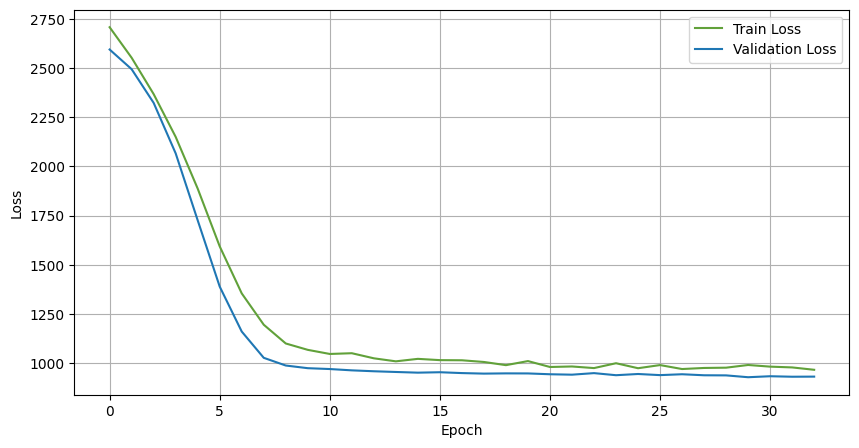

In [28]:
#Grafico
plt.figure(figsize=(10, 5))
plt.plot(MLP_history.history['loss'], label='Train Loss', color='#61a13a')
plt.plot(MLP_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
#Allenamento del modello
MLP_start_time2 = time.time()

MLP_new_history = MLP_model.fit(X_train, y_train, epochs=epochs, verbose=1, batch_size = batch_size, validation_data=(X_test, y_test))

MLP_end_time2 = time.time()

MLP_training2_time = MLP_end_time2 - MLP_start_time2

Epoch 1/33
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 923.9606 - val_loss: 931.2440
Epoch 2/33
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 957.3390 - val_loss: 931.8142
Epoch 3/33
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 930.7400 - val_loss: 929.3824
Epoch 4/33
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 999.7047 - val_loss: 931.7314
Epoch 5/33
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 967.6684 - val_loss: 929.1627
Epoch 6/33
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 954.4100 - val_loss: 928.6443
Epoch 7/33
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 930.9902 - val_loss: 933.1774
Epoch 8/33
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1019.0156 - val_loss: 927.5637
Epoch 9/33
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 933.1279 - val_loss: 918.0715
Epoch 10/33
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 928.1944 - val_loss: 915.6313
Epoch 11/33
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 990.6541 - val_loss: 922.5596
Epoch 12/33
32/32 ━━━━━━━━━━━

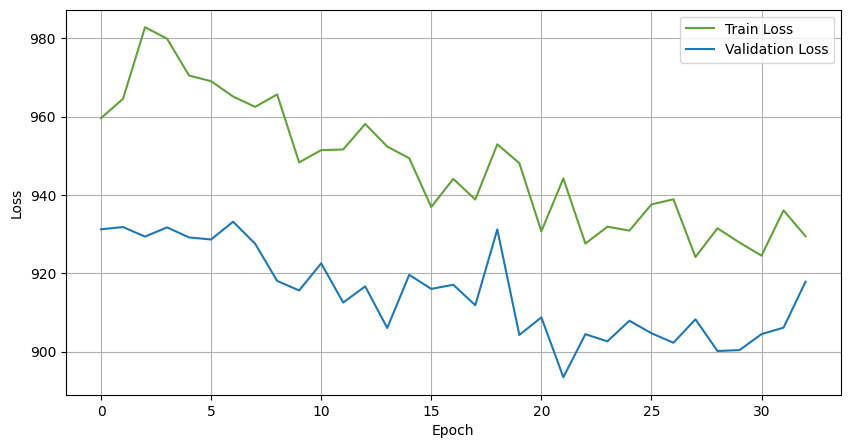

In [30]:
#Grafico
plt.figure(figsize=(10, 5))
plt.plot(MLP_new_history.history['loss'], label='Train Loss', color='#61a13a')
plt.plot(MLP_new_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
#Predizione dei valori
MLP_predictions = MLP_model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


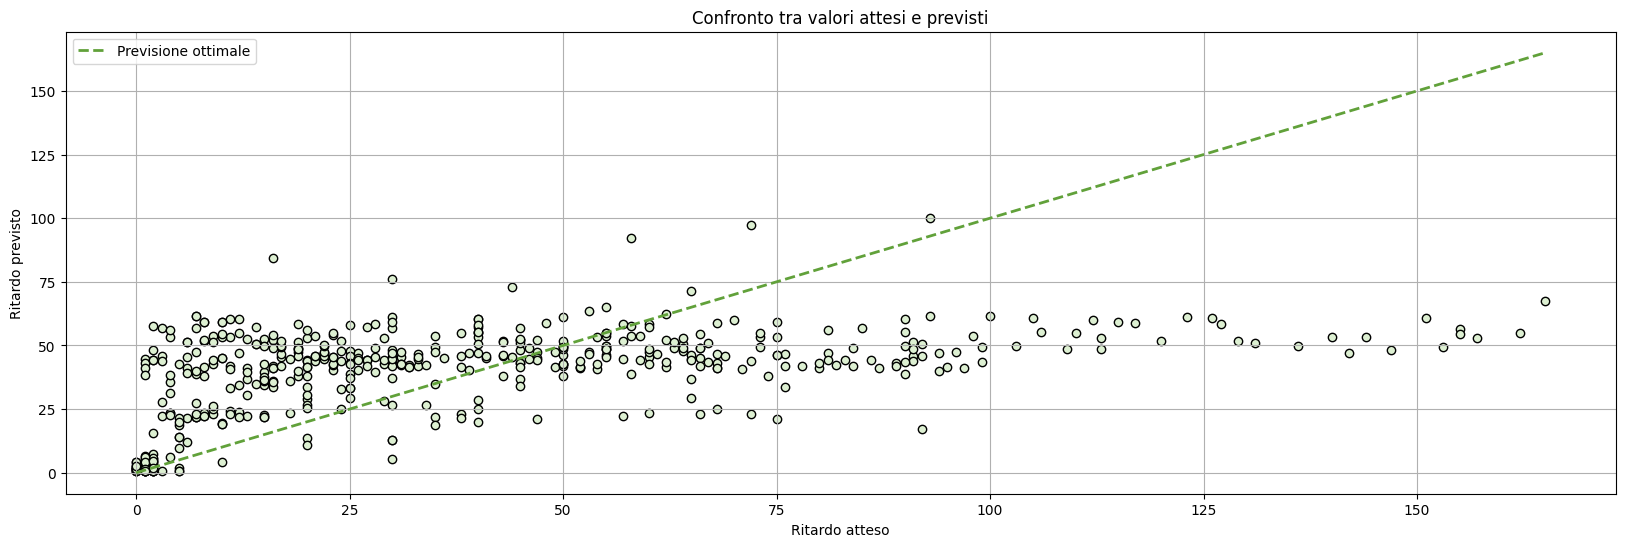

In [32]:
# Grafico Valori attesi vs valori previsti
plt.figure(figsize=(20, 6))
plt.scatter(y_test, MLP_predictions, color="#ddf0d2",edgecolors='black', alpha = 1)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='#61a13a', linestyle='--', label='Previsione ottimale',  linewidth=2)
plt.xlabel('Ritardo atteso')
plt.ylabel('Ritardo previsto')
plt.legend()
plt.title('Confronto tra valori attesi e previsti')
plt.grid()
plt.show()

In [34]:
#Valuto il modello
MLP_r2 = r2_score(y_test, MLP_predictions)
MLP_mae = mean_absolute_error(y_test, MLP_predictions)
MLP_mse = mean_squared_error(y_test, MLP_predictions)
MLP_time = MLP_training1_time + MLP_training2_time

print("R²: ", MLP_r2)

print("Errore assoluto medio: ",MLP_mae )

print("Errore quadratico medio: ",MLP_mse )

print("Tempo di addestramento (s): ",MLP_time )

R²:  0.23929190635681152
Errore assoluto medio:  22.70101890724618
Errore quadratico medio:  917.8765866774181
Tempo di addestramento (s):  17.905883312225342


# **KAN vs MLP**

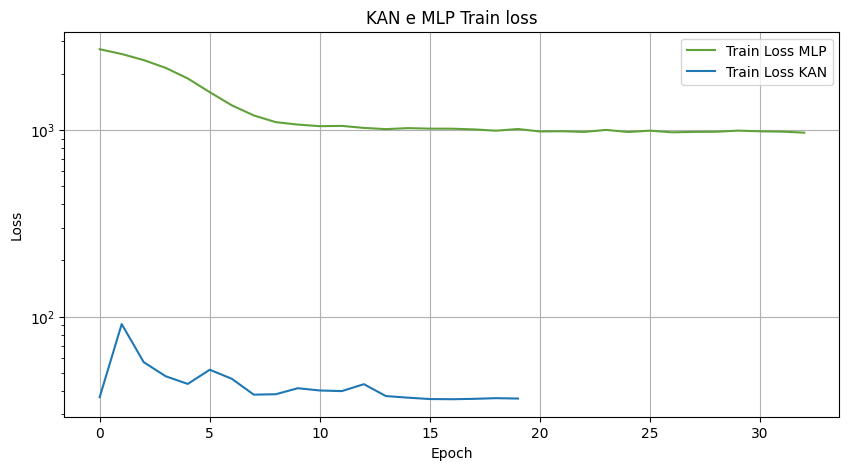

In [35]:
#Confronto train loss
plt.figure(figsize=(10, 5))
plt.plot(MLP_history.history['loss'], label='Train Loss MLP', color='#61a13a')
plt.plot(KAN_new_results["train_loss"], label='Train Loss KAN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.title('KAN e MLP Train loss')
plt.show()

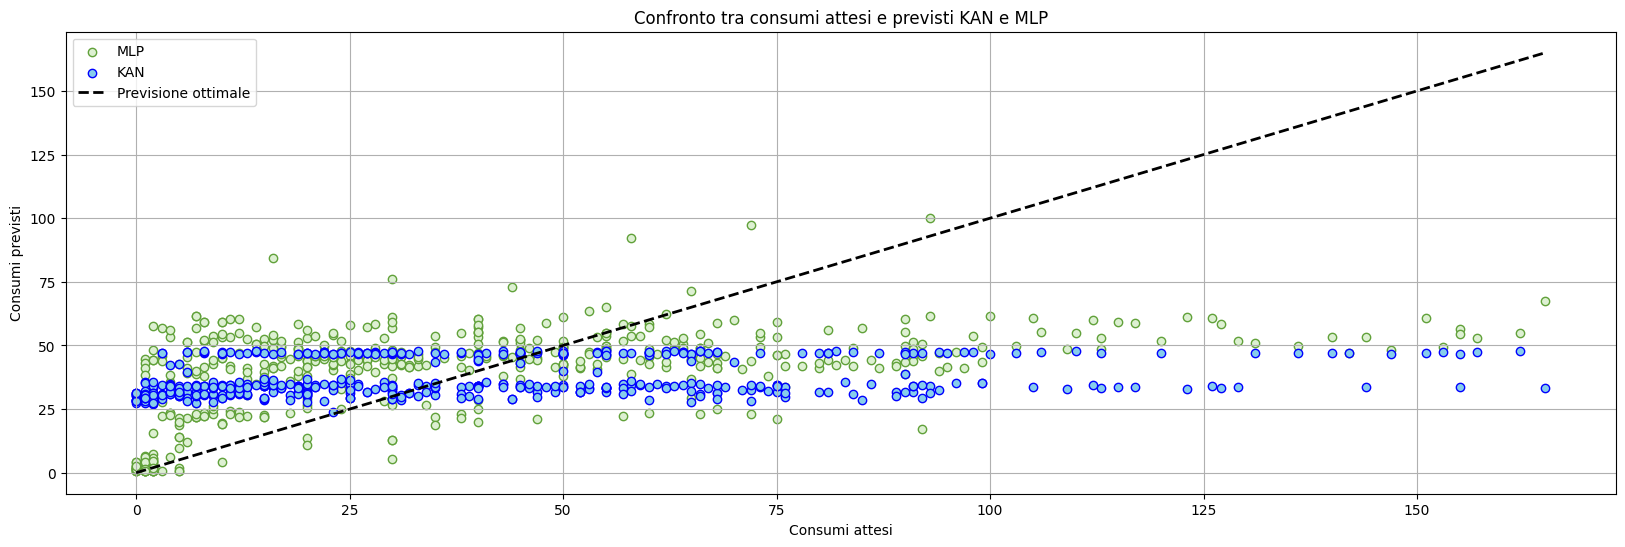

In [36]:
# Grafico Valori attesi vs valori previsti
plt.figure(figsize=(20, 6))
plt.scatter(y_test, MLP_predictions, color="#ddf0d2",edgecolors='#61a13a', alpha = 1, label='MLP')
plt.scatter(y_test, KAN_predictions, color ="skyblue",edgecolors='blue', alpha = 1, label='KAN')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle='--', label='Previsione ottimale',  linewidth=2)
plt.xlabel('Consumi attesi')
plt.ylabel('Consumi previsti')
plt.legend()
plt.grid()
plt.title('Confronto tra consumi attesi e previsti KAN e MLP')
plt.show()

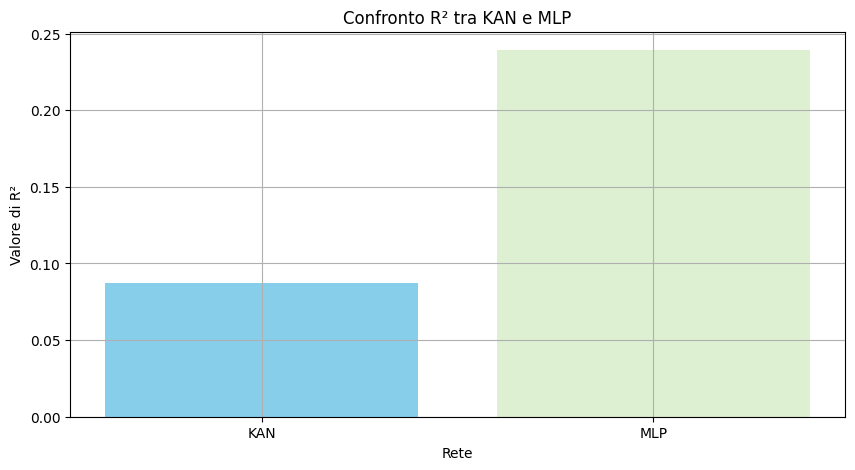

R² KAN:  0.08720755577087402
R² MLP:  0.23929190635681152


In [37]:
rete = ['KAN', 'MLP']
r_2 = [KAN_r2, MLP_r2]

plt.figure(figsize=(10, 5))
plt.bar(rete, r_2, color=["skyblue", "#ddf0d2"])
plt.xlabel('Rete')
plt.ylabel('Valore di R²')
plt.title('Confronto R² tra KAN e MLP')
plt.grid(True)
plt.show()

print("R² KAN: ", KAN_r2)
print("R² MLP: ", MLP_r2)

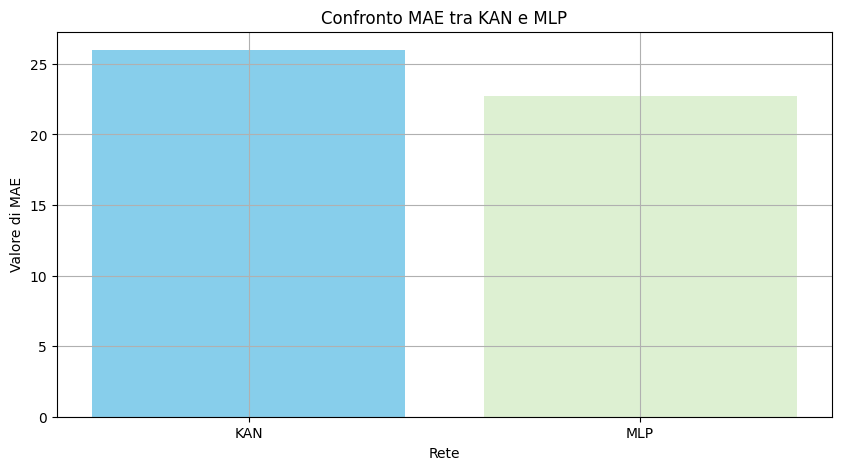

MAE KAN:  25.976241677999496
MAE MLP:  22.70101890724618


In [38]:
rete = ['KAN', 'MLP']
mae = [KAN_mae, MLP_mae]

plt.figure(figsize=(10, 5))
plt.bar(rete, mae, color=["skyblue", "#ddf0d2"])
plt.xlabel('Rete')
plt.ylabel('Valore di MAE')
plt.title('Confronto MAE tra KAN e MLP')
plt.grid()
plt.show()

print("MAE KAN: ", KAN_mae)
print("MAE MLP: ", MLP_mae)

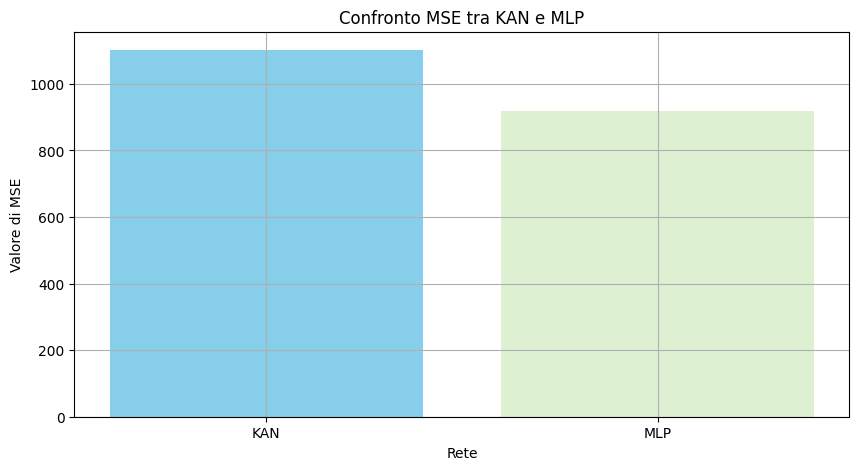

MSE KAN:  1101.3828900880087
MSE MLP:  917.8765866774181


In [39]:
rete = ['KAN', 'MLP']
mse = [KAN_mse, MLP_mse]

plt.figure(figsize=(10, 5))
plt.bar(rete, mse, color=["skyblue", "#ddf0d2"])
plt.xlabel('Rete')
plt.ylabel('Valore di MSE')
plt.title('Confronto MSE tra KAN e MLP')
plt.grid()
plt.show()

print("MSE KAN: ", KAN_mse)
print("MSE MLP: ", MLP_mse)

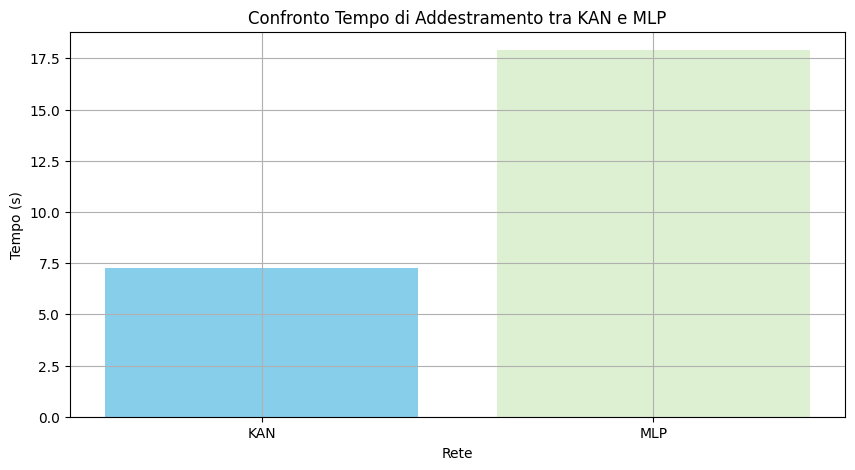

Tempo KAN:  7.2680439949035645
Tempo MLP:  17.905883312225342


In [41]:
rete = ['KAN', 'MLP']
mse = [KAN_time, MLP_time]

plt.figure(figsize=(10, 5))
plt.bar(rete, mse, color=["skyblue", "#ddf0d2"])
plt.xlabel('Rete')
plt.ylabel('Tempo (s)')
plt.title('Confronto Tempo di Addestramento tra KAN e MLP')
plt.grid()
plt.show()

print("Tempo KAN: ", KAN_time)
print("Tempo MLP: ", MLP_time)